# 🗑️ 재활용 품목 분류를 위한 Object Detection EDA for fold4

## 1. 필요 패키지 import 및 라벨 색 팔레트 지정

In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

## 2. 데이터셋 불러오기

In [2]:
# coco = COCO('../dataset/train.json')
coco = COCO('/data/ephemeral/home/level2-objectdetection-cv-05/data/dataset/json_folder/StratifiedGroupKFold/val_fold_4.json')

train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [3]:
train_df.head()

image_id   class_name  class_id  x_min  y_min   x_max  y_max
0  train/4096.jpg  Plastic bag         7  291.6  350.2   942.4  761.9
1  train/0003.jpg   Paper pack         2  462.2  369.4   696.1  624.0
2  train/0003.jpg    Styrofoam         6  773.3    3.0   961.7  431.4
3  train/0004.jpg        Paper         1  567.5  462.2   732.7  551.6
4  train/0004.jpg        Paper         1  859.4  411.7  1023.6  612.6

# 3. Annotations Per Image

### 3.1 Distribution of Annotaions Per Image

In [4]:
fig = px.histogram(train_df.image_id.value_counts(), 
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF ANNOTATIONS PER IMAGE   " \
                         "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",)
fig.show()

### 3.2 Box Plot

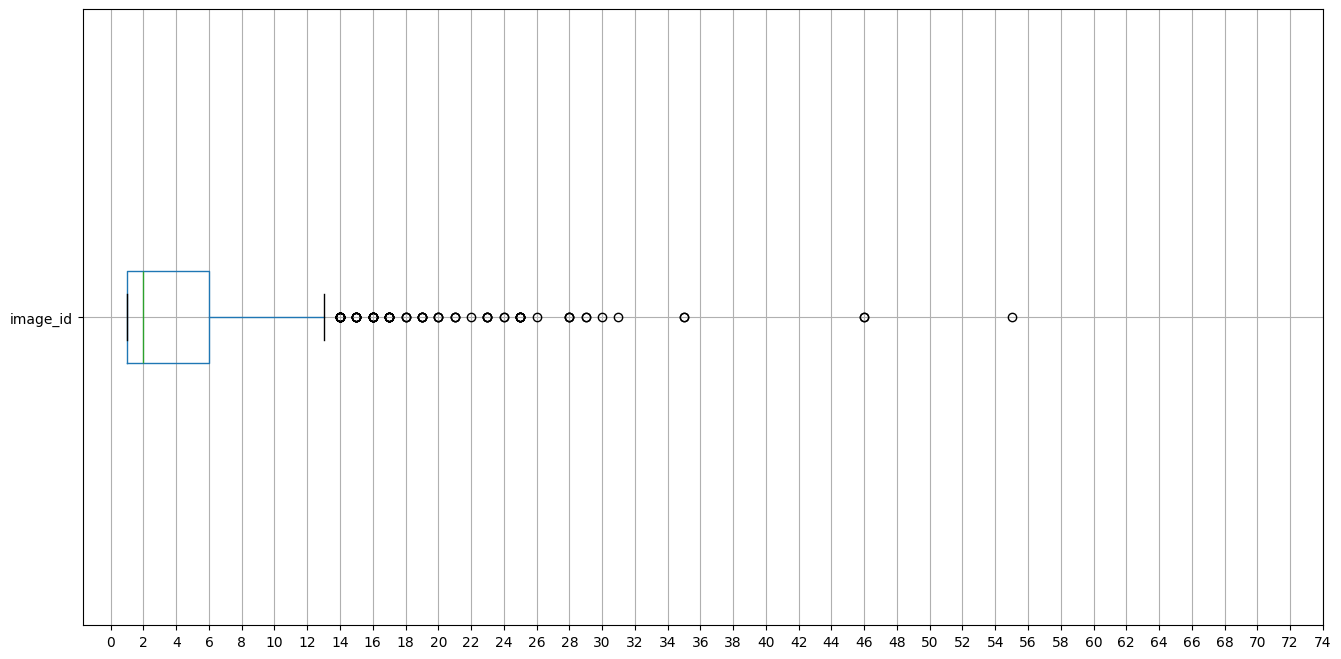

In [5]:
plt.figure(figsize=(16, 8))
boxplot = train_df.image_id.value_counts().to_frame().boxplot(vert=False, figsize=(16, 1.5))
plt.xticks(np.arange(0, 75, step=2))
plt.show()

# 4. Unique Class / Image
- 한 이미지내에 포함한 class 개수 분포

In [6]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)), 
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique class"},
             title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE   " \
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",)
fig.show()

# 5. Annotatiosn / Class
- 가장 적은 클래스는 `Battery`로 총 30개가 있다.
- 가장 많은 클래스는 `Paper`로 총 1167개가 있다.

## 5.1 Class Distribution

In [7]:
train_df.groupby(['class_name', 'class_id']).size().sort_values(ascending=True).to_frame().style.background_gradient(cmap='Blues')

In [8]:
fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

## 5.2 Battery 클래스를 가진 이미지는 몇 개의 클래스와 함께 있을까?
- 배터리가 포함된 이미지가 포함한 클래스 개수는 2.5개 이하가 50%이고, 3개이하가 75%이므로 배터리만 잘 구별할 수 있을 수준이다. 

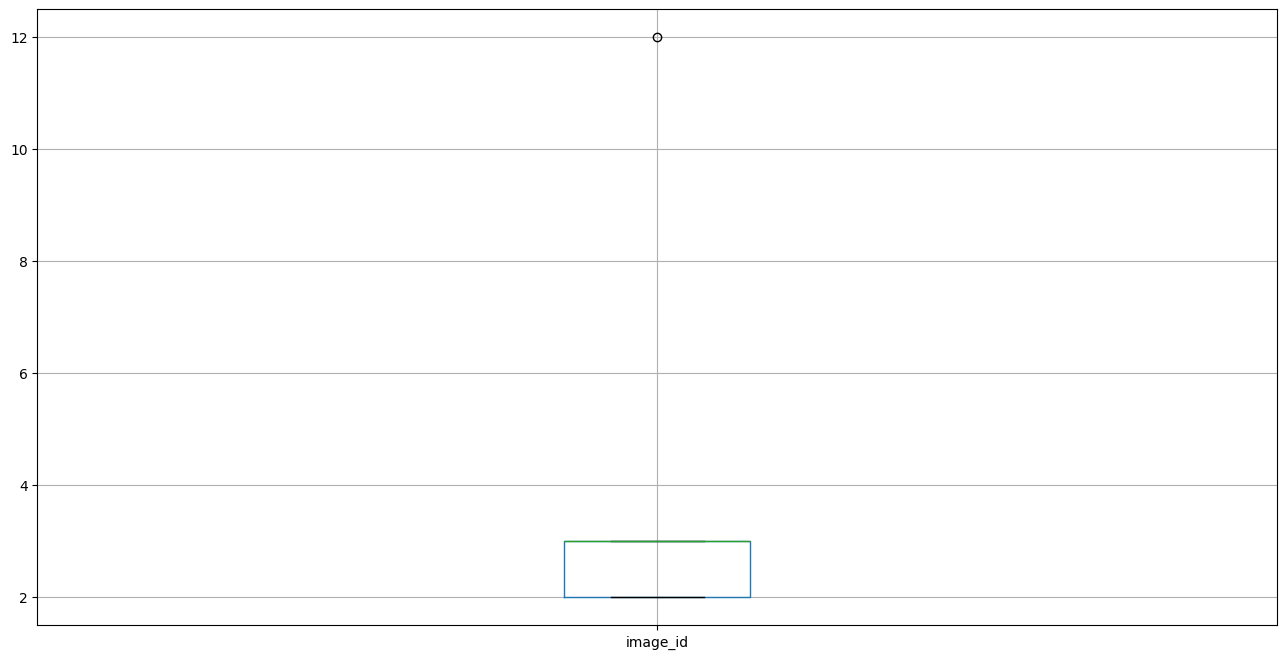

In [9]:
plt.figure(figsize=(16, 8))
train_df[train_df.class_name == 'Battery'].groupby('image_id')['image_id'].count().to_frame().boxplot()
plt.show()

### + Battery 클래스의 박스 크기는 어느 정도 될까? 구별이 가능한 수준인가?
- 전체 이미지에서 평균 4.8%, 2/3의 데이터가 5%이하 정도의 넓이를 차지하는 수준으로 매우 낮은 수준의 해상도가 있을 것으로 예상된다.

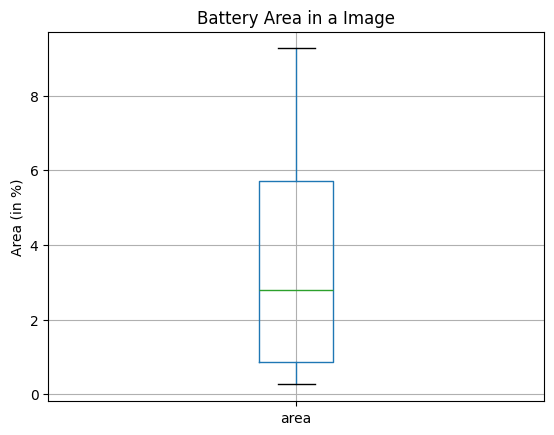

In [10]:
battery = train_df[train_df.class_name == 'Battery']

w_and_h = pd.DataFrame()
for x_min, y_min, x_max, y_max in battery[['x_min', 'y_min', 'x_max', 'y_max']].values:
    weight = (x_max / 1024) - (x_min / 1024)
    height = (y_max / 1024) - (y_min / 1024)
    area = weight * height * 100
    w_and_h = w_and_h.append(pd.DataFrame({'weight': [weight], 'height': [height], 'area': [area]}))

plt.title('Battery Area in a Image')
boxplot = w_and_h['area'].to_frame().boxplot(figsize=(16, 8))
plt.ylabel('Area (in %)')
plt.show()

In [11]:
w_and_h['area'].describe()

count    30.000000
mean      3.467658
std       2.766779
min       0.261732
25%       0.858781
50%       2.802177
75%       5.705114
max       9.264144
Name: area, dtype: float64

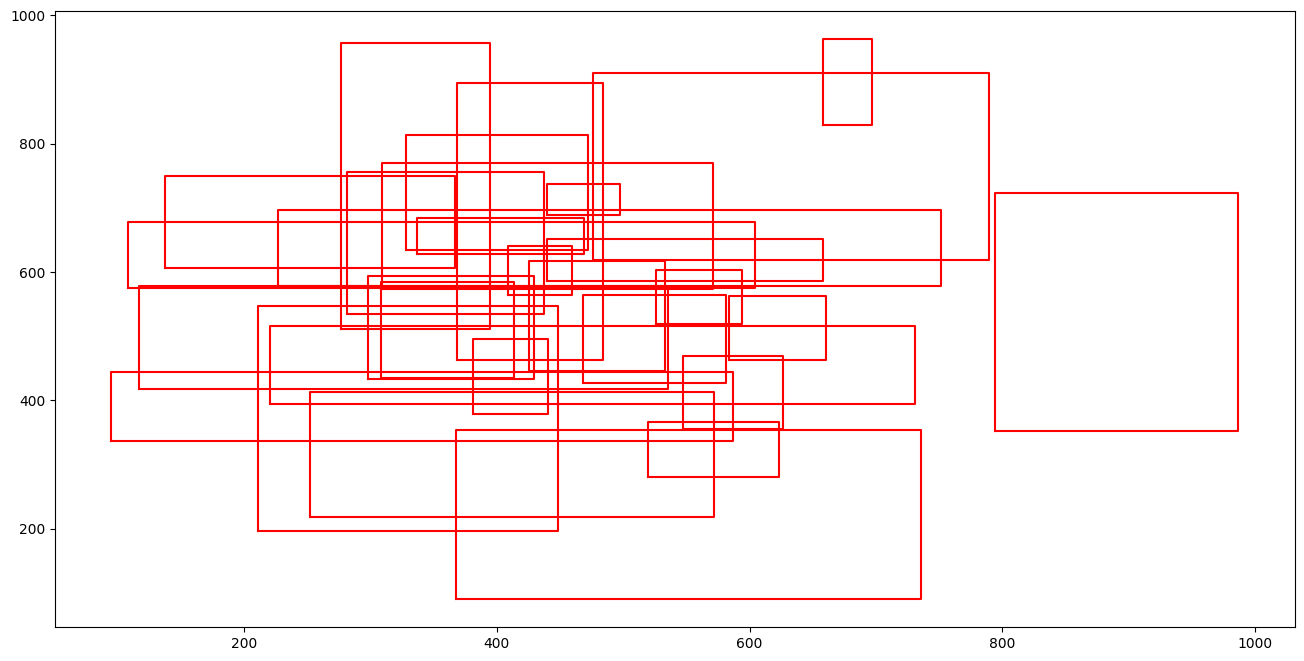

In [12]:
plt.figure(figsize=(16, 8))
for x_min, y_min, x_max, y_max in battery[['x_min', 'y_min', 'x_max', 'y_max']].values:
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r')
plt.show()

# 6. Object heatmap
- 이미지에서 bbox가 주로 어디에 위치하는지를 알아보기 위한 분포
- 대부분의 이미지가 중앙에 위치한다.
- `Paper Pack`의 경우 다른 클래스들보다 더 중앙에 위치한 경우가 많다.
- 배터리의 경우 다른 클래스들 보다 더 산재해 있는 것을 알 수 있다.

  0%|          | 0/4508 [00:00<?, ?it/s]

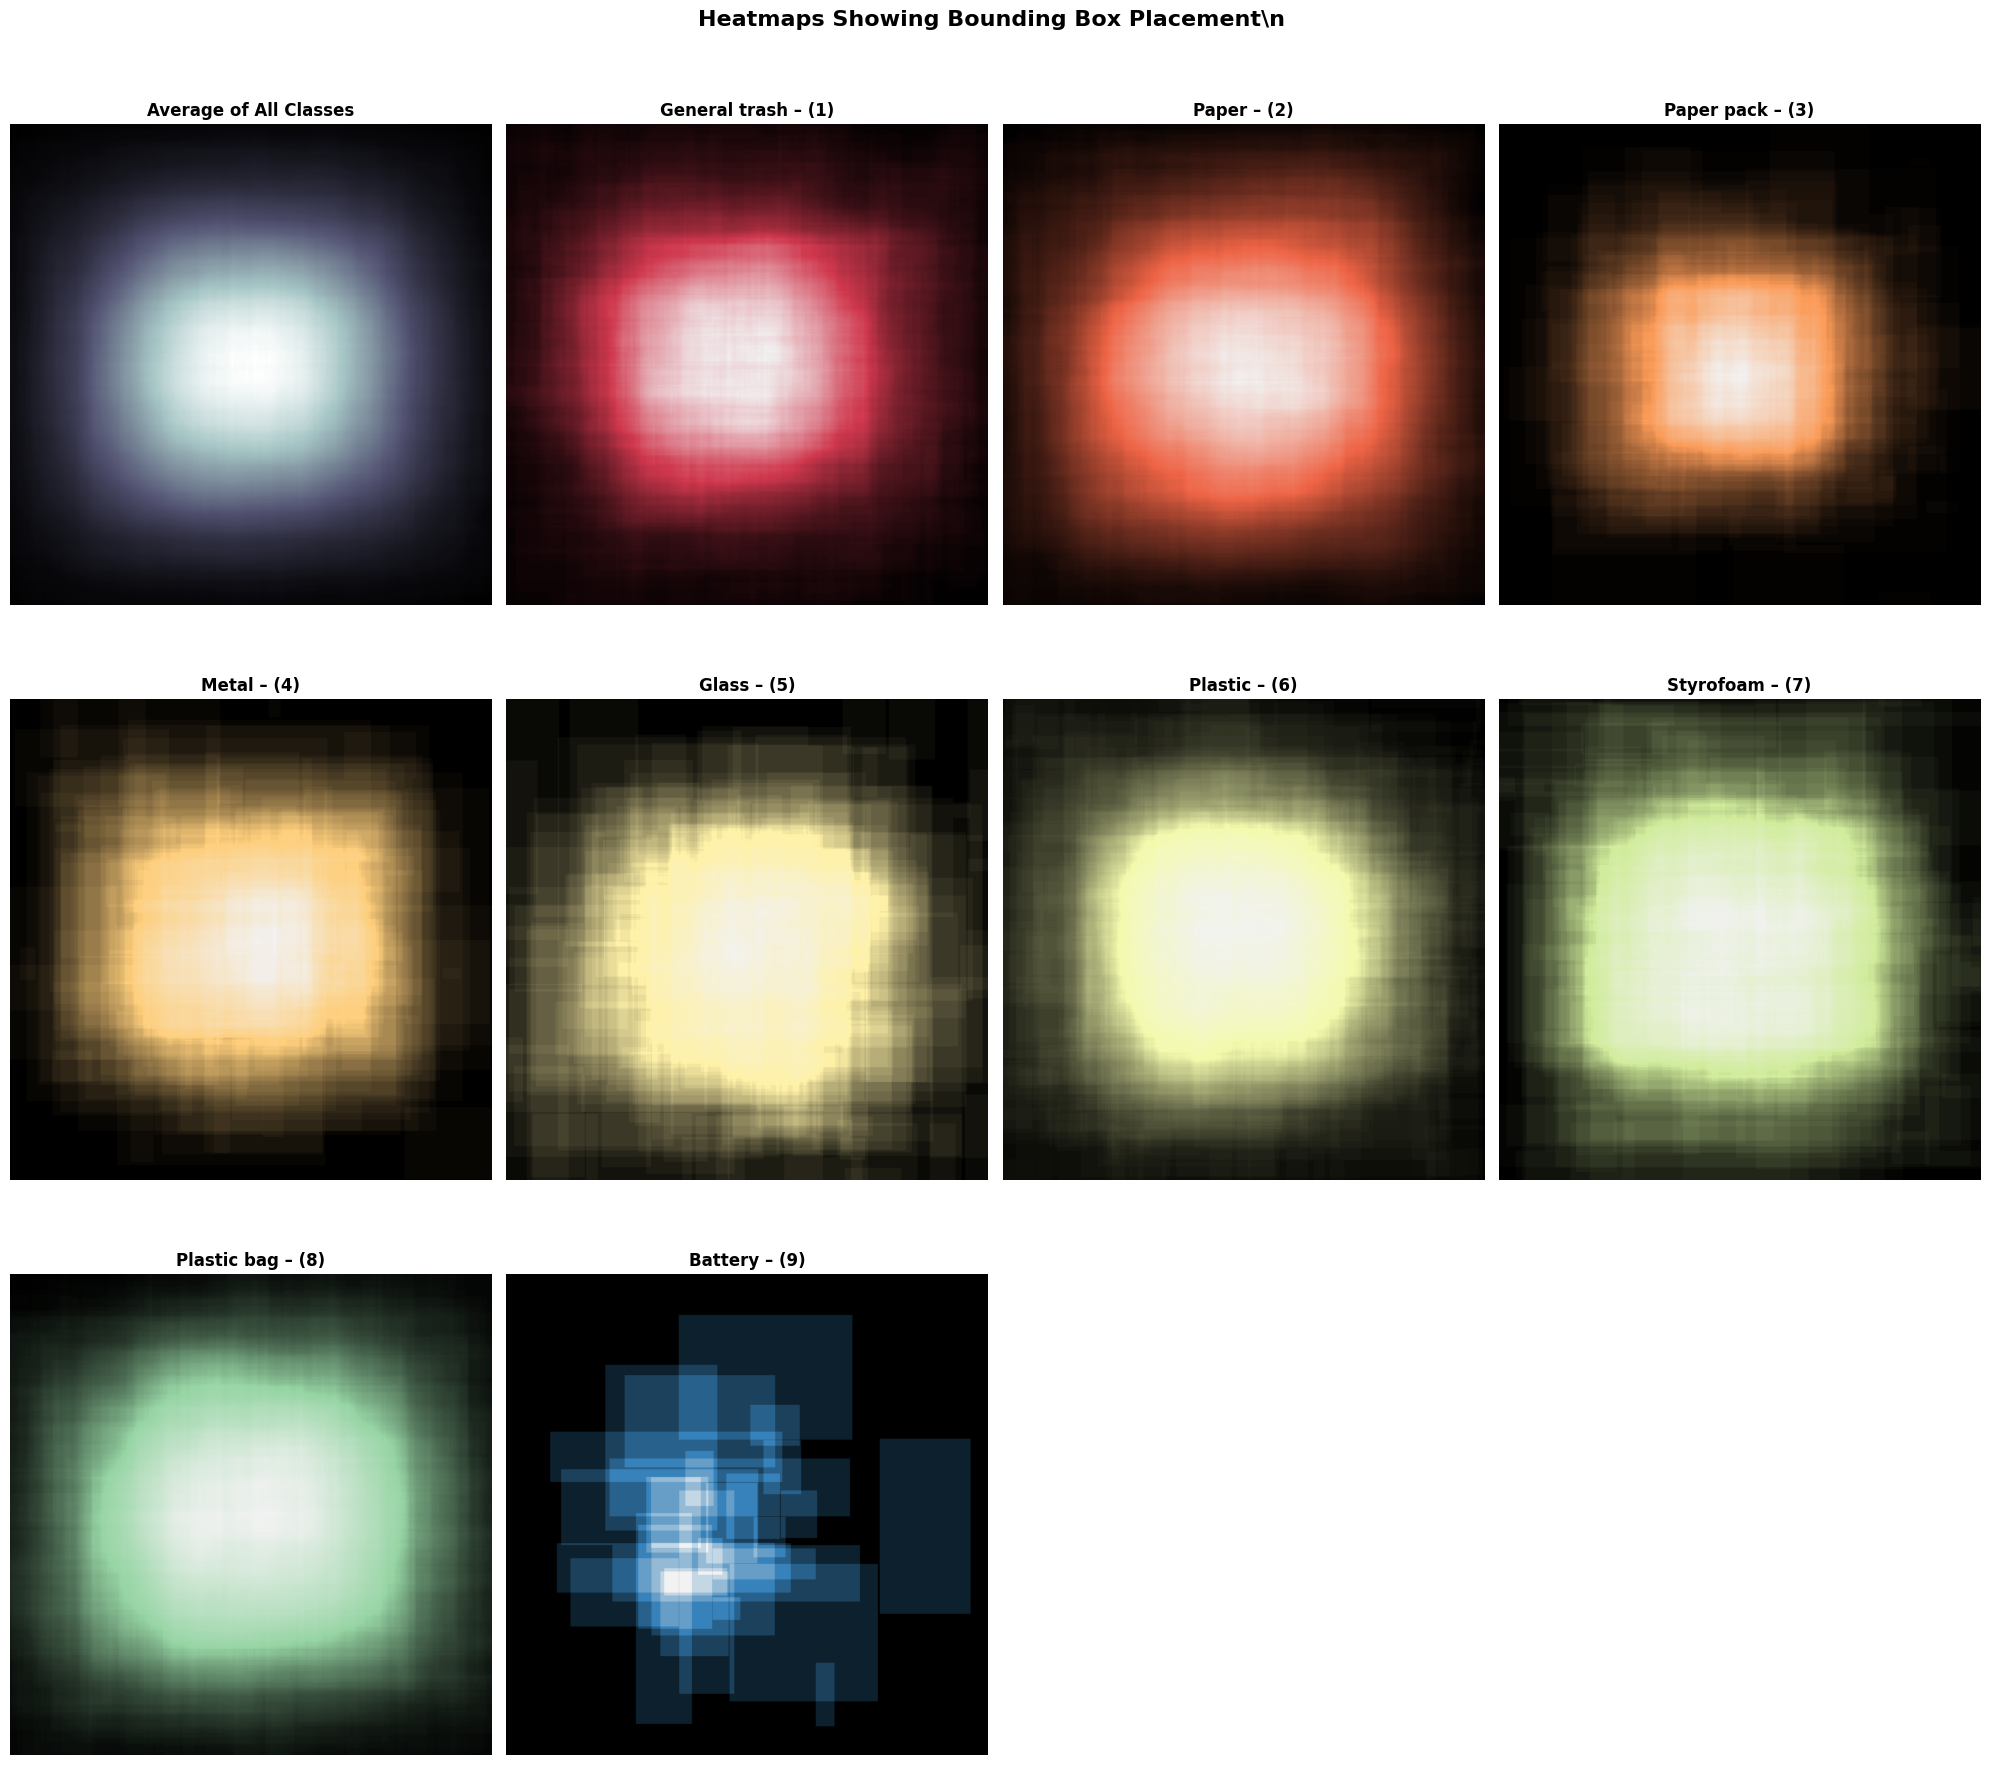

In [13]:
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values / 1024
bbox_df['x_max'] = train_df['x_max'].values / 1024
bbox_df['y_min'] = train_df['y_min'].values / 1024
bbox_df['y_max'] = train_df['y_max'].values / 1024
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024

ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT
HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize
heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff
custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
        name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
]
custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]):
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
    
fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)
for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold")
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} – ({i})", fontweight="bold")
        
    plt.axis(False)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 7. Distribution of Bounding Box Area
- 각 class별 bounding box의 크기 분포
- `Clothing` 클래스가 가장 차지한 면접의 분포가 고르게 넓다.
- `Battery`, `General trash`, `Glass`, `Plastic` 75%이하의 데이터들이 전체 면적에서 1/10 미만의 면적을 차지한다.

In [14]:
# Update bbox dataframe to make this easier
bbox_df["frac_bbox_area"] = (bbox_df["frac_x_max"]-bbox_df["frac_x_min"])*(bbox_df["frac_y_max"]-bbox_df["frac_y_min"])
# bbox_df["class_id_as_str"] = bbox_df["class_id"].map(classes)
display(bbox_df.head())

fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="frac_bbox_area", color="class_name", 
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, notched=True,
             labels={"class_name":"Class Name", "frac_bbox_area":"BBox Area (%)"},
             title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA   " \
                   "<i><sub>(Some Upper Outliers Excluded For Better Visualization)</sub></i></b>")

fig.update_layout(showlegend=True,
                  yaxis_range=[-0.025,0.4],
                  legend_title_text=None,
                  xaxis_title="",
                  yaxis_title="<b>Bounding Box Area %</b>",)
fig.show()

class_id   class_name     x_min     x_max     y_min     y_max  frac_x_min  \
0         7  Plastic bag  0.284766  0.920312  0.341992  0.744043    0.284766   
1         2   Paper pack  0.451367  0.679785  0.360742  0.609375    0.451367   
2         6    Styrofoam  0.755176  0.939160  0.002930  0.421289    0.755176   
3         1        Paper  0.554199  0.715527  0.451367  0.538672    0.554199   
4         1        Paper  0.839258  0.999609  0.402051  0.598242    0.839258   

   frac_x_max  frac_y_min  frac_y_max  frac_bbox_area  
0    0.920312    0.341992    0.744043        0.255522  
1    0.679785    0.360742    0.609375        0.056792  
2    0.939160    0.002930    0.421289        0.076972  
3    0.715527    0.451367    0.538672        0.014085  
4    0.999609    0.402051    0.598242        0.031460